# Quantum Channel for the Ancilla Density Matrix in Random Unitary Circuit

![](RUC.png)

We are going to evaluate the effect of the matrices along the diagonal slice on the ancilla density matrix. After summing over the indices $(s_1,s_2)$ for a neighbouring pair of sites we lose the final layer by unitarity, and we are left with:

![](MPO.png)

The input ancilla density matrix $\rho_{a_1a_2a_3,\bar a_1\bar a_2 \bar a_3}$ will be contracted in at the bottom, and the indices of the output matrix $\rho'_{b_1b_2b_3,\bar b_1\bar b_2 \bar b_3}$ will pop out of the top. The task is to evaluate $\rho'$ for a given assignment of indices $b_j$ if all components of $\rho$ are known.

The first thing to notice is that the final index is traced over, lowering the dimension of the density matrix before we start. We then work from the [middle out](https://www.youtube.com/watch?v=0rhdOt9bOHE), contracting in a $U$ and $\bar U$ at each step. This is an $O(N^2)$ operation, where $N=q^d$ for depth $d$.

In [1]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import sys
sys.path.append("../")

In [2]:
from ruc_einsum import (cptp_map, apply_gates, tensor_trace, trace_square, matrix_to_tensor, 
                        tensor_to_matrix, random_ρ, random_gates, random_state, inner_product)

## Einsum path optimization

In [3]:
q = 2
depth = 3
gates = random_gates(q, depth)
ρ = random_ρ(q, depth)
path = np.einsum_path('aACx,bBCy,ab...->AB...xy', gates[0], gates[0].conj(), ρ, optimize='greedy')

In [4]:
print(path[0])

['einsum_path', (0, 1), (0, 1)]


In [5]:
print(path[1])

  Complete contraction:  aACx,bBCy,abpcRO->ABpcROxy
         Naive scaling:  11
     Optimized scaling:  10
      Naive FLOP count:  6.144e+03
  Optimized FLOP count:  2.305e+03
   Theoretical speedup:  2.666
  Largest intermediate:  2.560e+02 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   7           bBCy,aACx->ABabxy                  abpcRO,ABabxy->ABpcROxy
  10     ABabxy,abpcRO->ABpcROxy                       ABpcROxy->ABpcROxy


In [6]:
path = np.einsum_path('aACx,bBDy,CDab...->AB...xy', gates[0], gates[0].conj(), ρ, optimize='greedy')

In [7]:
print(path[0])

['einsum_path', (0, 2), (0, 1)]


In [8]:
print(path[1])

  Complete contraction:  aACx,bBDy,CDabRO->ABROxy
         Naive scaling:  10
     Optimized scaling:  8
      Naive FLOP count:  3.072e+03
  Optimized FLOP count:  1.025e+03
   Theoretical speedup:  2.997
  Largest intermediate:  6.400e+01 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   8         CDabRO,aACx->ADORbx                      bBDy,ADORbx->ABROxy
   8         ADORbx,bBDy->ABROxy                           ABROxy->ABROxy


In [9]:
path = np.einsum_path('Cx,Dy,CD...->...xy', gates[-1][0, 0], gates[-1][0, 0].conj(), ρ, optimize=True)

In [10]:
print(path[0])

['einsum_path', (0, 2), (0, 1)]


In [11]:
print(path[1])

  Complete contraction:  Cx,Dy,CDpcRO->pcROxy
         Naive scaling:  8
     Optimized scaling:  7
      Naive FLOP count:  7.680e+02
  Optimized FLOP count:  5.130e+02
   Theoretical speedup:  1.497
  Largest intermediate:  6.400e+01 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   7           CDpcRO,Cx->DORcpx                        Dy,DORcpx->pcROxy
   7           DORcpx,Dy->pcROxy                           pcROxy->pcROxy


## Complexity

In [12]:
timeit_results = []
q = 2
depths =  np.arange(5,13)
for d in depths:
    res = %timeit -o cptp_map(random_ρ(q, d), random_gates(q, d))
    timeit_results.append(res.average)

1.74 ms ± 42 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.83 ms ± 601 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.94 ms ± 789 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14 ms ± 609 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
72.3 ms ± 9.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
395 ms ± 52.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.17 s ± 134 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
14.6 s ± 205 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Check the $4^d$ scaling

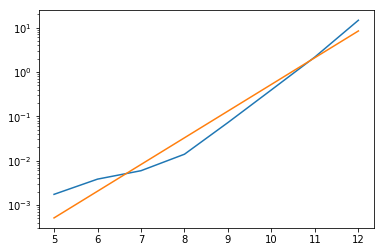

In [13]:
plt.semilogy(depths, timeit_results, depths, 0.0000005*4**depths)

## CPTP map simulation

In [6]:
q = 2
depth = 12
# ρ = np.zeros(2*depth*[q])
# ρ[tuple(2*depth*[0])] = 1
ρ = random_ρ(q, depth)
purity_trace = np.array([])
eigenvalues = np.array([])

for step in range(100):
    purity_trace = np.append(purity_trace, trace_square(ρ))
    eigenvalues = np.concatenate([eigenvalues, eigh(tensor_to_matrix(ρ), eigvals_only=True)])
    ρ = cptp_map(ρ, random_gates(q, depth))
    print("step ", step)

step  0
step  1
step  2
step  3
step  4
step  5
step  6
step  7
step  8
step  9
step  10
step  11
step  12
step  13
step  14
step  15
step  16
step  17
step  18
step  19
step  20
step  21
step  22
step  23
step  24
step  25
step  26
step  27
step  28
step  29
step  30
step  31
step  32
step  33
step  34
step  35
step  36
step  37
step  38
step  39
step  40
step  41
step  42
step  43
step  44
step  45
step  46
step  47
step  48
step  49
step  50
step  51
step  52
step  53
step  54
step  55
step  56
step  57
step  58
step  59
step  60
step  61
step  62
step  63
step  64
step  65
step  66
step  67
step  68
step  69
step  70
step  71
step  72
step  73
step  74
step  75
step  76
step  77
step  78
step  79
step  80
step  81
step  82
step  83
step  84
step  85
step  86
step  87
step  88
step  89
step  90
step  91
step  92
step  93
step  94
step  95
step  96
step  97
step  98
step  99


## Purity from CPTP map

In [7]:
np.mean(purity_trace)

(0.08077306508143389-4.770970262010412e-19j)

In [8]:
-np.log(np.mean(purity_trace))

(2.5161117219820848+5.906635160124738e-18j)

In [10]:
-np.log((4/5)**12)

2.6777226157705165

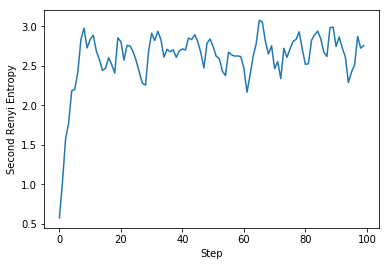

In [11]:
plt.plot(-np.log(np.real(purity_trace)))
plt.xlabel("Step")
plt.ylabel("Second Renyi Entropy");

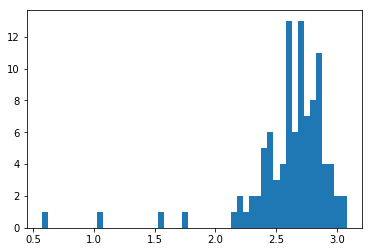

In [12]:
plt.hist(-np.log(np.real(purity_trace)), bins=50);

## Spectrum

/Users/austen/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
/Users/austen/anaconda/lib/python3.6/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/austen/anaconda/lib/python3.6/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


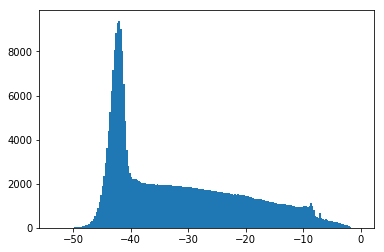

In [13]:
plt.hist(np.log(eigenvalues), bins=200);

Compare with fully random density matrix

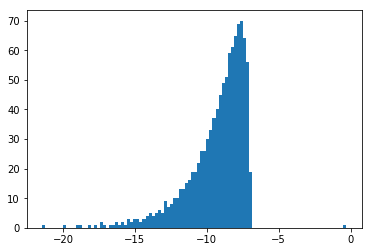

In [31]:
plt.hist(np.log(eigh(tensor_to_matrix(random_ρ(2, 10)), eigvals_only=True)), bins=100);

## Purity from Trajectories

Now we try it the second way using the relationship

$$
\gamma = \mathrm tr\left[\rho_A^2\right] = \mathbb{E}_{x_1:x_N,\atop y_1:y_N}|\langle\psi_{x_1:x_N}|\psi_{y_1:y_N}\rangle|^2
$$

where $|\psi_{x_1:x_N}\rangle$ represents a normalized ancilla state arising from the trajectory $x_1:x_N$, where each step of the trajetory consists of a pair $x_j=(x^{(1)}_j, x^{(2)}_{j})$, where $x^{(1,2)}_j\in 1,\ldots q$.

__Note__ that this way requires one extra unitary as we don't do the sum over $x_j$.

In [51]:
q = 2
depth = 10
state1 = random_state(q, depth)
state2 = state1
purity_traj = np.array([])

for step in range(10000):
    purity_traj = np.append(purity_trace, np.abs(inner_product(state1, state2))**2)
    gates = random_gates(q, depth + 1) # Need one more gate than in the CPTP case
    state1 = apply_gates(state1, gates)
    state2 = apply_gates(state2, gates)
    if step % 1000 == 0:
        print("step ", step)

step  0
step  1000
step  2000
step  3000
step  4000
step  5000
step  6000
step  7000
step  8000
step  9000


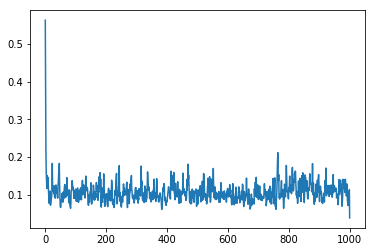

In [52]:
plt.plot(purity_traj)

In [53]:
np.mean(purity_traj)

(0.10626561493164043-2.1590314665381085e-19j)

In [54]:
(4/5)**10

0.10737418240000006